In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import allel
os.environ['R_USER'] = 'D:\Anaconda3\Lib\site-packages\rpy2'
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri as rpyn
pandas2ri.activate()

plt.style.use('ggplot')



In [166]:
home = os.path.expanduser('~')
directory = os.path.join('Imp_Research','Dataset')

pop_name = 'BFcol.3R'

# ignore 3L choromosome for now
filename = f'haplotype.intergenic.{pop_name}.Rdata'
data_path = os.path.join(home, directory, filename)

data = robjects.r['load'](data_path)
data

'haplotype','POS'


In [88]:
type(robjects.r['haplotype'])

Type :  <class 'rpy2.robjects.vectors.Matrix'>


In [194]:
# taking the transpose
haplotype = np.array(robjects.r['haplotype']).T
haplo_len = len(haplotype)
haplotype.shape

(4836295, 150)

In [195]:
POS = np.array(robjects.r['POS'])
POS.shape

(4836295,)

In [208]:
# def all_filters(self, LD_window_size, LD_overlap_step, MBP_start = 1, MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=1):

bfcol = FilterSNP(haplotype,POS)
bfcol_H,bfcol_P = bfcol.all_filters(LD_window_size = 500,LD_overlap_step = 100,LD_iter = 3)

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 150)
2.) Filtering Rare Allels
Number of SNPs removed =  3450127
Retaining =  201593
3.) Performing LD Pruning
iteration 1 retaining 94486 removing 107107 variants
Retained Matrix =  (94486, 150)


### Coverting Datasets from Rdata to HDF5 
#### Removes a lot of dependencies. We only need Pandas

In [7]:
'''
Converting from Rdata and saving datasets in HDF5 format with compression.
Naming : key1.key2.Population.arm.hd5
e.g, Haplotype.POS.BFcol.3L.hd5

Preferrably use as a .py script in terminal for efficiency.
'''

populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
              'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
              'GW','KE','UGgam']
chromo_arms = ['3R','3L']
for population in populations:
    for arm in chromo_arms:
        
        pop_name = population+'.'+arm
        filename = f'haplotype.intergenic.{pop_name}.Rdata'
        data_path = os.path.join(home, directory, filename)
        store_path = os.path.join(home,directory,"HDF_Dataset")

        data = robjects.r['load'](data_path)
        # storing transpose of Haplotype because sk-allel takes SNP x samples as input
        haplotype = np.array(robjects.r['haplotype'],dtype=np.uint8).T
        POS = np.array(robjects.r['POS'])

        # To read the dataset, keys present in name can be used : 'Haplotype' and 'POS'
        storefile = os.path.join(store_path, f'Haplotype.POS.{pop_name}.hd5')
        hap = pd.DataFrame(haplotype).astype('int8')
        pos = pd.DataFrame(POS)
        # To prevent out of memory error Delete the variables
        del haplotype, POS
        hap.to_hdf(storefile,key='Haplotype',format='fixed',mode='w',complevel=9)
        del hap
        pos.to_hdf(storefile,key='POS',format='fixed',mode='a',complevel=9)
        del pos


KeyboardInterrupt: 

In [13]:
# CMgam couldn't be loaded via R packages available for Python

data_path1 = os.path.join(home, directory, 'CMgam.3R.1.RData')
data_path2 = os.path.join(home, directory, 'CMgam.3R.2.RData')
data_path3 = os.path.join(home, directory, 'CMgam.3R.3.RData')

data1 = robjects.r['load'](data_path1)
print(data1)
H = np.array(robjects.r['haplotype1'],dtype=np.uint8).T
P = np.array(robjects.r['POS1'])

print(H.shape, P.shape)

data2 = robjects.r['load'](data_path2)
print(data2)
H = np.append(H,np.array(robjects.r['haplotype1'],dtype=np.uint8).T,axis = 1)

print(H.shape, P.shape)

data3 = robjects.r['load'](data_path3)
print(data3)
H = np.append(H,np.array(robjects.r['haplotype1'],dtype=np.uint8).T,axis =1)
# P = np.append(P,robjects.r['POS1'],axis=1)

print(H.shape, P.shape)

store_path = os.path.join(home,directory,"HDF_Dataset")
storefile = os.path.join(store_path, f'Haplotype.POS.CMgam.3R.hd5')
hap = pd.DataFrame(H).astype('int8')
pos = pd.DataFrame(P)
print(hap.shape," ",pos.shape)
# To prevent out of memory error Delete the variables
del H,P
hap.to_hdf(storefile,key='Haplotype',format='fixed',mode='w',complevel=9)
del hap
pos.to_hdf(storefile,key='POS',format='fixed',mode='a',complevel=9)
del pos

[1] "haplotype1" "POS1"      

(4836295, 200) (4836295,)
[1] "haplotype1" "POS1"      

(4836295, 400) (4836295,)
[1] "haplotype1" "POS1"      

(4836295, 594) (4836295,)
(4836295, 594)   (4836295, 1)


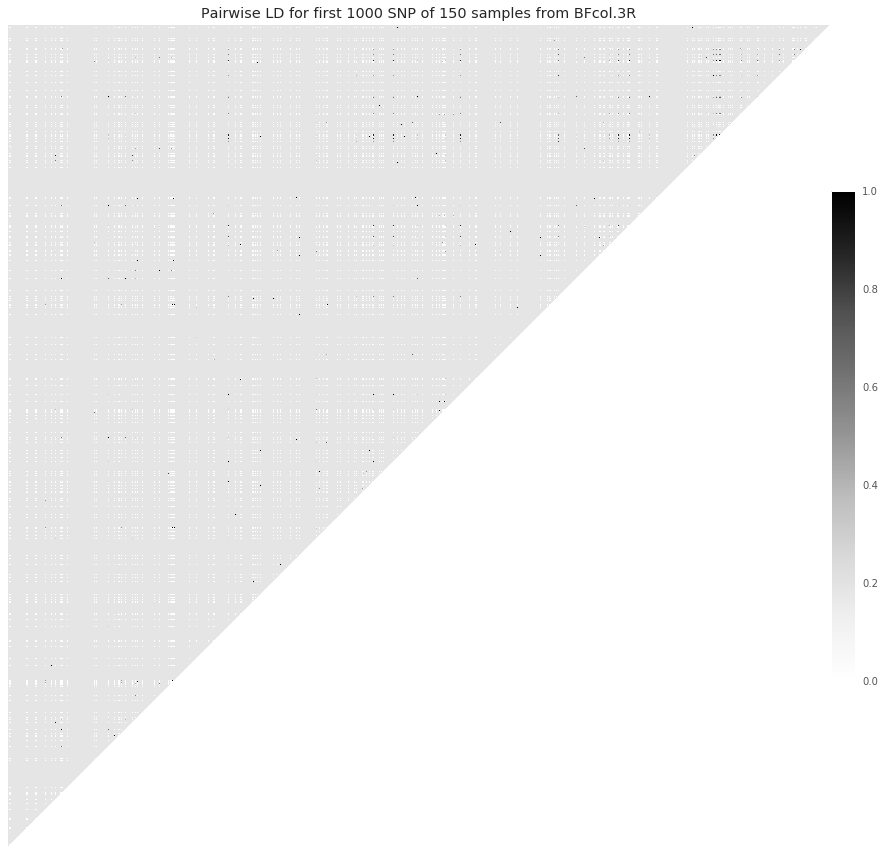

In [186]:
# Funtion definitions are changed in scikit-allel 
# refer the documentation before using the code
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn)**2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)
plot_ld(haplotype[:1000], 'Pairwise LD for first 1000 SNP of 150 samples from BFcol.3R')

### Selecting 1-37MBP

In [169]:
'''
get_MBP()
Funtction takes in POS array, start and end Mega Base Pair 
return : Indices of the MBPs
'''
# runs in 12.6 seconds
# def get_MBP(POS,start = 1,end = 37):
#     index = []
#     for i in range(len(POS)):
#         if POS[i] > 1000000 and POS[i] <= 37000000:
#             index.append(i)
#     return index

# Library function runs in 0.16 seconds

def get_MBP(POS,start = 1,end = 37):
    return np.where(POS[np.where(POS>=1e6)]<=37e6)[0]

# import timeit
# start = timeit.default_timer()
# index = get_MBP2(POS)
# stop = timeit.default_timer()
# print(stop-start)
# >>> 0.16424157
'''
get_haplo_MBP()
takes a haplotype matrix and POS 
returns haplotype matrix with only selected MBP positions, POS
'''
def get_haplo_MBP(haplotype,POS,start = 1,end = 37):
    index = get_MBP(POS,start,end)
    return np.take(haplotype,index,0),np.take(POS,index,0)


In [170]:
haplotypeF,POSF = get_haplo_MBP(haplotype,POS)
haplotypeF.shape
# 3651720 SNPs are left

(3651720, 150)

In [171]:
POSF.shape

(3651720,)

### Filtering SNPs with Rare Allele using Minor Allel Frequency (MAF)

In [161]:
'''
The function removes the rare allel using minor frequency threshold.
MFA means an allel with lower relative count. MAF0 = Count(0)/Total
if MAF > 0.5 then its major otherwise minor, and vice versa.

Params: Haplotype Matrix, Threshold in percent
return : Filtered Haplotype Matrix,POS
'''

def filter_MAF(haplo,threshold = 5):
    if threshold >= 50 : 
        print("MAF threshold cannot be more than 49%")
        return
    samples = haplo.shape[1]
    sums = haplo.sum(axis=1)
    maf = get_MAF(haplo)
    #indexes = np.where(maf >= threshold*0.01)[0]
    minor = samples*threshold/100
    major = samples*(100-threshold)/100
    # Selects indexes where allels are >threshold or all 0 and all 1.
    indexes = np.where((sums>=minor)& (sums<=major))[0]
    print("Number of SNPs removed = ",len(haplo)-len(indexes))
    return np.take(haplo,indexes,0)

# Returns : Array of MAF
def get_MAF(haplo):
    samples = haplo.shape[1]
    sums = haplo.sum(axis=1)
    maf = []
    for s in sums:
        if s != samples or s != 0:
            frequency = s/samples
            if frequency > 0.5:
                maf.append(1-frequency)
            else: 
                maf.append(frequency)
    return np.array(maf)

In [172]:
# MAF values before filtering
maf_before = get_MAF(haplotypeF)

In [173]:
haplotypeF = filter_MAF(haplotypeF)
print(haplotypeF.shape)
maf_after = get_MAF(haplotypeF)

Number of SNPs removed =  3450127
(201593, 150)


(array([3450127.,   77495.,   38084.,   21112.,   16370.,   12815.,
           9805.,    8625.,    9050.,    8237.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 <a list of 10 Patch objects>)

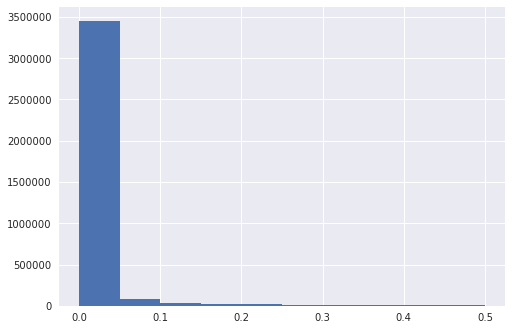

In [150]:
plt.hist(maf_before)

Text(0.5, 0.98, 'MAF of SNPs of BFcol.3R before minor allel filtering')

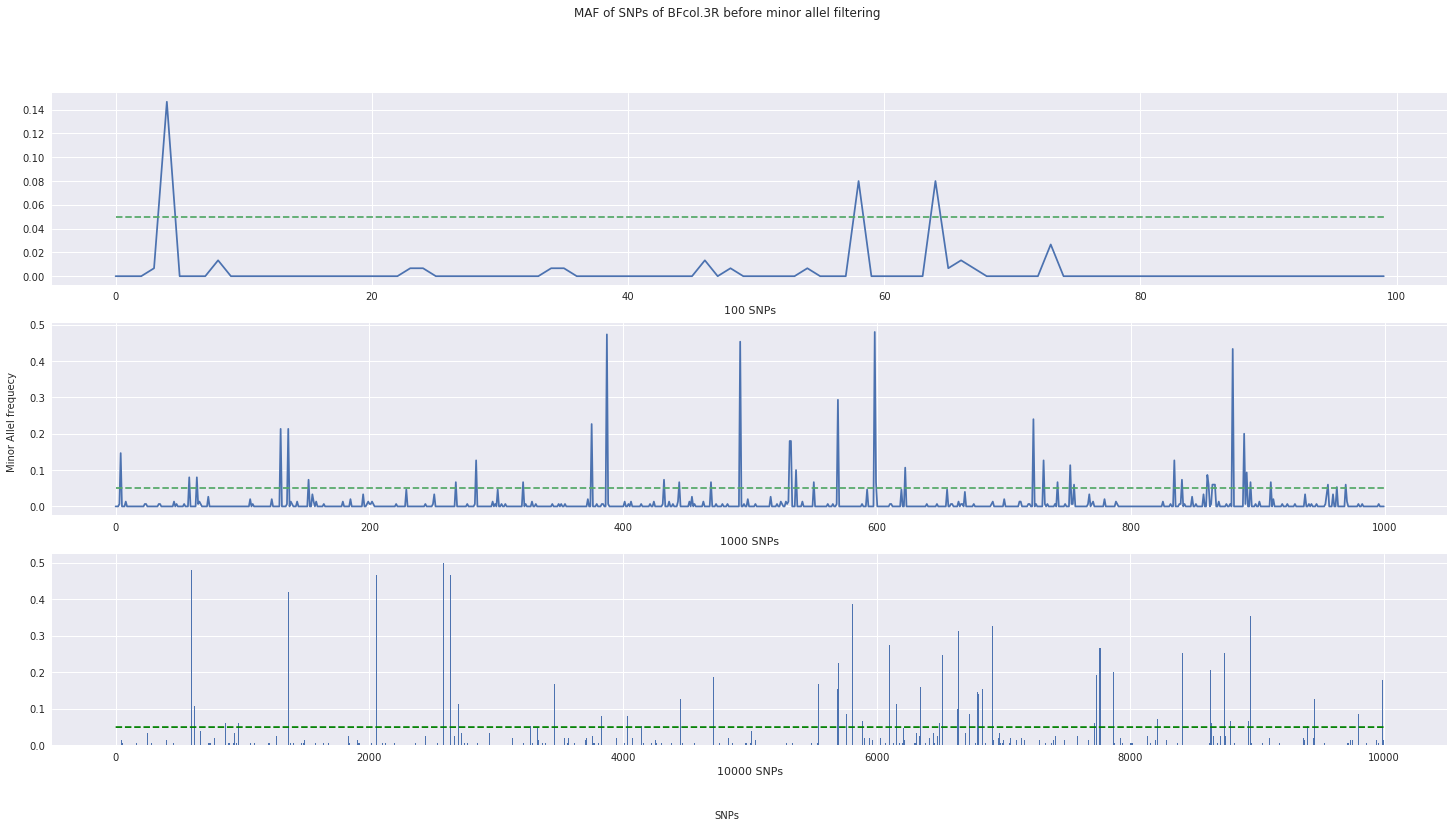

In [81]:
x = range(0,len(maf_before))

plt.style.use('seaborn')
fig, ax = plt.subplots(3, 1,figsize=(25,12))
ax[0].plot(x[:100],maf_before[:100])
ax[0].plot(x[:100],[0.05]*100,linestyle='dashed')
ax[1].plot(x[:1000],maf_before[:1000])
ax[1].plot(x[:1000],[0.05]*1000,linestyle='dashed')
ax[2].bar(x[:10000],maf_before[:10000])
ax[2].plot(x[:10000],[0.05]*10000,linestyle='dashed',color='g')

ax[0].set_xlabel('100 SNPs')
ax[1].set_xlabel('1000 SNPs')
ax[2].set_xlabel('10000 SNPs')
fig.text(0.5, 0.04, 'SNPs', ha='center')
fig.text(0.1, 0.5, 'Minor Allel frequecy', va='center', rotation='vertical')
fig.suptitle(f'MAF of SNPs of {pop_name} before minor allel filtering')

Text(0.5, 0.98, 'MAF of SNPs of BFcol.3R after filtering minor allel at each SNP')

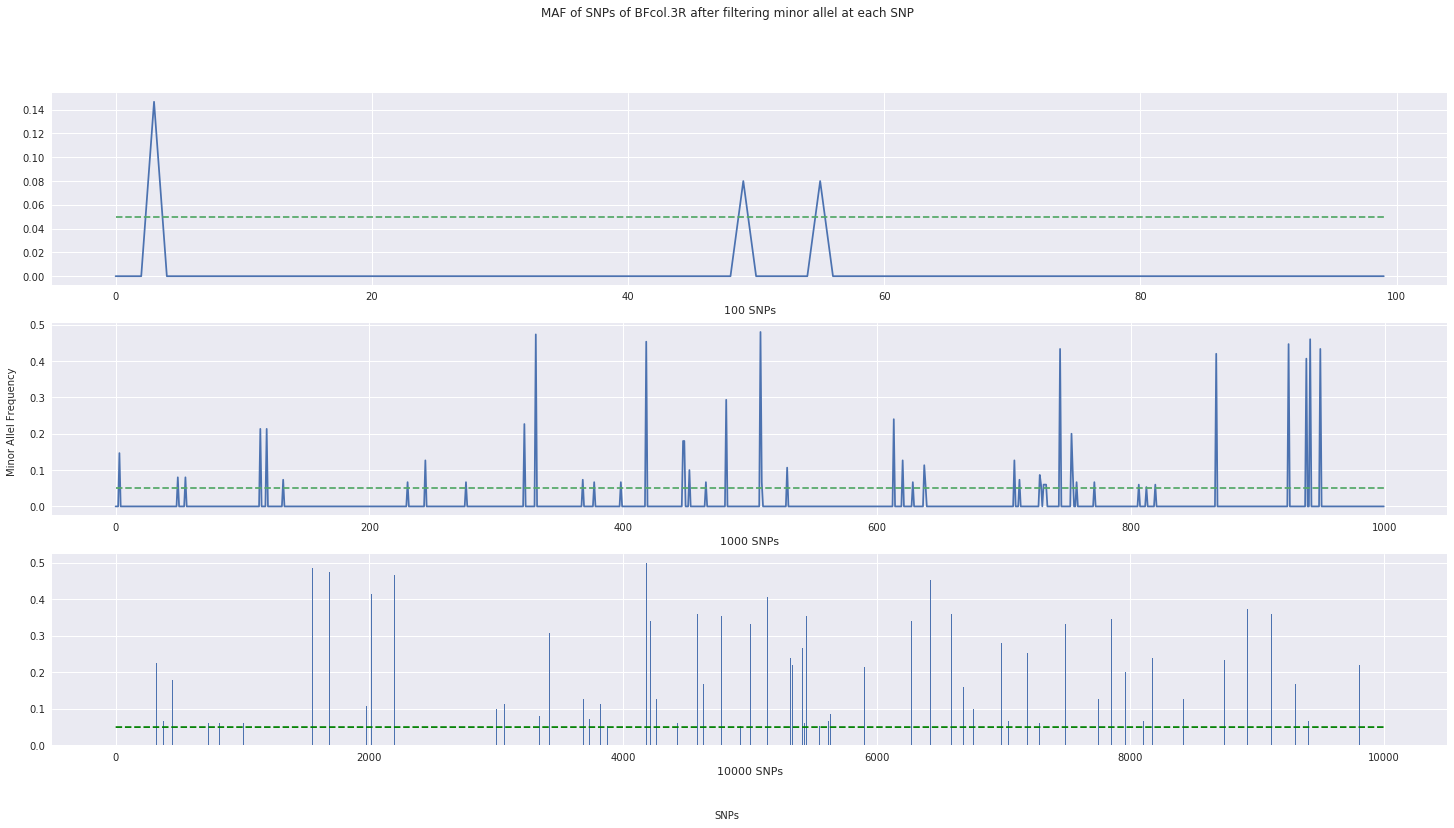

In [82]:
x = range(0,len(maf_after))[:10000]


plt.style.use('seaborn')
fig, ax = plt.subplots(3, 1,figsize=(25,12))
ax[0].plot(x[:100],maf_after[:100])
ax[0].plot(x[:100],[0.05]*100,linestyle='dashed')
ax[1].plot(x[:1000],maf_after[:1000])
ax[1].plot(x[:1000],[0.05]*1000,linestyle='dashed')
ax[2].bar(x[:10000],maf_after[:10000])
ax[2].plot(x[:10000],[0.05]*10000,linestyle='dashed',color='g')

ax[0].set_xlabel('100 SNPs')
ax[1].set_xlabel('1000 SNPs')
ax[2].set_xlabel('10000 SNPs')
fig.text(0.5, 0.04, 'SNPs', ha='center')
fig.text(0.1, 0.5, 'Minor Allel Frequency', va='center', rotation='vertical')
fig.suptitle(f'MAF of SNPs of {pop_name} after filtering minor allel at each SNP')

Text(0.5, 1.0, 'MAF Histogram after MAF filtering')

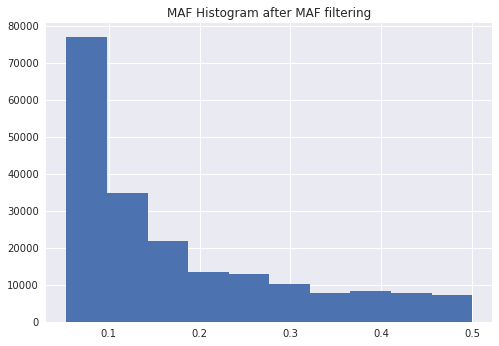

In [151]:
plt.hist(maf_after)
plt.title('MAF Histogram after MAF filtering')

### LD Pruning (Alistair's Method)

In [176]:
'''
Params : 
gn = Haplotype Matrix
size = window size to be consdered for LD calculation and pruning
step = overlap size between windows
threshold = Maximum value of r**2 to include variants. 
'''

def ld_pruning(gn, size, step, threshold=.1, n_iter=1):
    for i in range(n_iter):
        loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
        n = np.count_nonzero(loc_unlinked)
        n_remove = gn.shape[0] - n
        print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
        gn = gn.compress(loc_unlinked, axis=0)
    return gn

In [177]:
# Takes a long long time on 2.7M SNP
# After filtering lesser are there ~202K in BFcol
# Threshold = 0.1
gnu = ld_pruning(haplotypeF, size=500, step=100, threshold=.1, n_iter=2)

iteration 1 retaining 94486 removing 107107 variants
iteration 2 retaining 85815 removing 8671 variants


In [190]:
BFcol_haploF = gnu.copy()
BFcol_haploF.shape

(85815, 150)

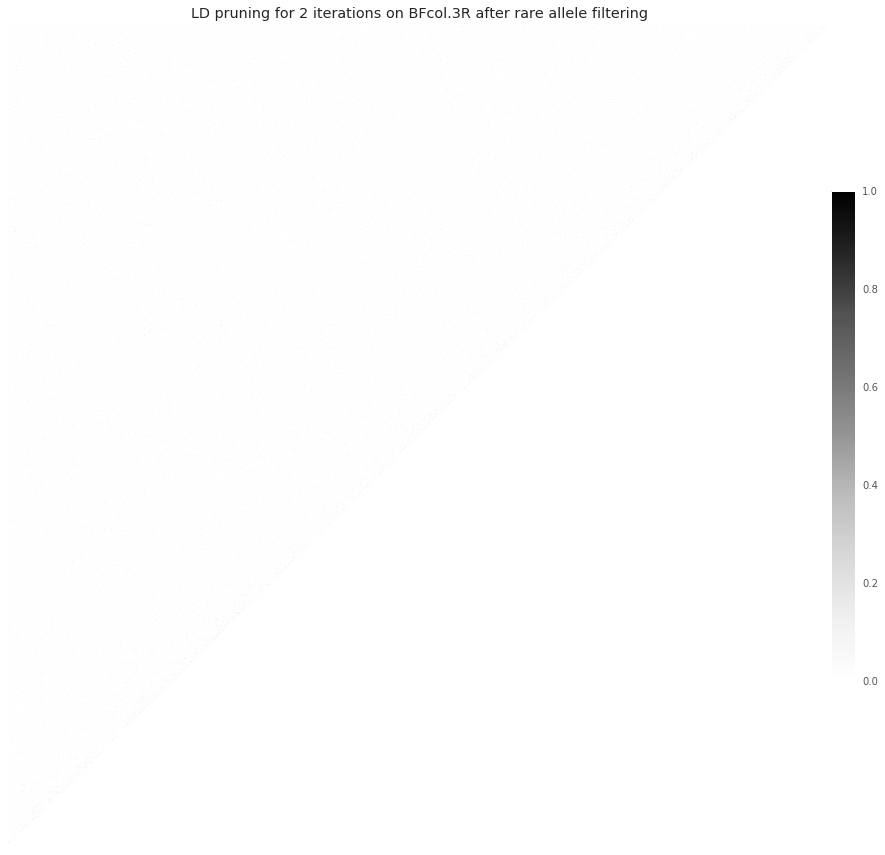

In [188]:
plot_ld(BFcol_haploF[:1000],'LD pruning for 2 iterations on BFcol.3R after rare allele filtering')

In [25]:
# For the time being, taking random 1% of MAF filtered SNP's
rindexes = np.random.randint(len(haplotypeF),size=int((len(haplotypeF)*0.01)))
haplotypeFF = haplotypeF[rindexes]
haplotypeFF.shape

(27979, 150)

### Generic Filtering Function

In [218]:
'''
Requirements : NumPy and Scikit-Allel
'''

class FilterSNP():
    def __init__(self,haplotype, POS):
        self.haplotype = haplotype
        self.POS = POS
        self.H = haplotype
        self.P = POS
        self._removed_maf = None
        self._retained_maf = None
        self._retained_ld = None
        self._removed_ld = None
        
    def all_filters(self, LD_window_size, LD_overlap_step, MBP_start = 1, MBP_end = 37, MAF_threshold = 5, LD_threshold=.1,LD_iter=1):
        print("1.) Selecting Mega Base Pairs")
        self.H,self.P = self.get_haplo_MBP(self.H,self.P,start = MBP_start, end = MBP_end)
        print("MBP selected. Retained Matrix = ", self.H.shape)
        print("2.) Filtering Rare Allels")
        self.H,self.P = self.filter_MAF(self.H,self.P,threshold = MAF_threshold)
        print("3.) Performing LD Pruning")
        self.H = self.LD_pruning(self.H, LD_window_size, LD_overlap_step, threshold = LD_threshold, n_iter = LD_iter)
        print("Retained Matrix = ", self.H.shape)
        
        return self.H, self.P

    def filter_MAF(self,haplo,POS,threshold = 5):
        if threshold >= 50 : 
            print("MAF threshold cannot be more than 49%")
            return
        samples = haplo.shape[1]
        sums = haplo.sum(axis=1)
        maf = get_MAF(haplo)
        #indexes = np.where(maf >= threshold*0.01)[0]
        minor = samples*threshold/100
        major = samples*(100-threshold)/100
        # Selects indexes where allels are >threshold or all 0 and all 1.
        indexes = np.where((sums>=minor)& (sums<=major))[0]
        print("Number of SNPs removed = ",len(haplo)-len(indexes))
        print("Retaining = ",len(indexes))
        self._removed_maf = len(haplo)-len(indexes)
        self._retained_maf = len(indexes)
        return np.take(haplo,indexes,0), np.take(POS,indexes,0)

    # Returns : Array of MAF
    def get_MAF(self,haplo):
        samples = haplo.shape[1]
        sums = haplo.sum(axis=1)
        maf = []
        for s in sums:
            if s != samples or s != 0:
                frequency = s/samples
                if frequency > 0.5:
                    maf.append(1-frequency)
                else: 
                    maf.append(frequency)
        return np.array(maf)

    def get_MBP(self,POS,start = 1,end = 37):
        return np.where(POS[np.where(POS>=1e6)]<=37e6)[0]

    def get_haplo_MBP(self,haplotype,POS,start = 1,end = 37):
        index = get_MBP(POS,start,end)
        return np.take(haplotype,index,0),np.take(POS,index,0)
    
    def LD_pruning(self,gn, size, step, threshold = .1, n_iter=1):
        removed = 0
        for i in range(n_iter):
            loc_unlinked = allel.locate_unlinked(gn, size=size, step=step, threshold=threshold)
            n = np.count_nonzero(loc_unlinked)
            n_remove = gn.shape[0] - n
            removed += n_remove
            print('iteration', i+1, 'retaining', n, 'removing', n_remove, 'variants')
            gn = gn.compress(loc_unlinked, axis=0)
        self._retained_ld = gn.shape[0]
        self._removed_ld = removed
        return gn

#### Filtering all the populations

In [ ]:
populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
              'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
              'GW','KE','UGgam']

# populations = ['GNgam','KE','UGgam']

# Taking only arm 3R
chromo_arms = ['3R']

# Dic. Stores all the filtered populations
# POS_pop = {} has ['GNgam','KE','UGgam']
# Haplo_pop = {} has ['GNgam','KE','UGgam']

Haplo_all = {}
POS_all = {}

for population in populations:
    for arm in chromo_arms:
        pop_name = population+'.'+arm
        filename = f'Haplotype.POS.{pop_name}.hd5'
        data_path = os.path.join(home, directory,"HDF_Dataset", filename)
    
        print(f'------{pop_name}------\n')
        H = pd.read_hdf(data_path,key='Haplotype').astype('int8').to_numpy().astype('int8')
        P = pd.read_hdf(data_path,key='POS').to_numpy()
        
        datafilter = FilterSNP(H,P)
        data_H,data_P = datafilter.all_filters(LD_window_size = 500,LD_overlap_step = 100,LD_iter = 3)
        del H,P
        Haplo_pop[pop_name] = data_H
        POS_pop[pop_name] = data_P
        del data_H,data_P

------BFcol.3R------

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 150)
2.) Filtering Rare Allels
Number of SNPs removed =  3450127
Retaining =  201593
3.) Performing LD Pruning


#### Storing Filtering Stats for all populations

In [232]:
populations = ['BFcol','BFgam','AOcol','CIcol','CMgam','FRgam',
              'GAgam','GHcol','GHgam','GM','GNcol','GNgam','GQgam',
              'GW','KE','UGgam']

# Taking only arm 3R
chromo_arms = ['3R']

# Storing : Pop Name, Initial Shape, SNPs Removed in Rare Allele Filtering, RAF Retained Shape, Removed in LD Pruning, Final Shape

columns = ['Population', 'Haplotypes', 'Initial_SNP', 'SNPs_removed_MAF', 'MAF_retained_shape','SNPs_removed_LD','Final_shape']
Filtering_stats = pd.DataFrame(columns = columns)

for population in populations:
    for arm in chromo_arms:
        stats = []
        pop_name = population+'.'+arm
        filename = f'Haplotype.POS.{pop_name}.hd5'
        data_path = os.path.join(home, directory,"HDF_Dataset", filename)
    
        print(f'------{pop_name}------\n')
        
        H = pd.read_hdf(data_path,key='Haplotype').astype('int8').to_numpy().astype('int8')
        P = pd.read_hdf(data_path,key='POS').to_numpy()
        
        stats.append(pop_name)
        stats.append(H.shape[1])
        stats.append(H.shape[0])
        datafilter = FilterSNP(H,P)

#       Window = 500, Overlap = 100, Iteration = 3
        data_H,data_P = datafilter.all_filters(LD_window_size = 500,LD_overlap_step = 100,LD_iter = 3)

        stats.append(datafilter._removed_maf)
        stats.append(datafilter._retained_maf)
        stats.append(datafilter._removed_ld)
        stats.append(data_H.shape[0])
        
#         Filtering_stats = Filtering_stats.append(pd.DataFrame([stats],columns = columns), ignore_index=True)
        Filtering_stats.loc[len(Filtering_stats)] = stats
    
        del data_H,data_P
        del H,P, datafilter

------BFcol.3R------

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 150)
2.) Filtering Rare Allels
Number of SNPs removed =  3450127
Retaining =  201593
3.) Performing LD Pruning
iteration 1 retaining 94486 removing 107107 variants
iteration 2 retaining 85815 removing 8671 variants
iteration 3 retaining 84145 removing 1670 variants
Retained Matrix =  (84145, 150)
------BFgam.3R------

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 184)
2.) Filtering Rare Allels
Number of SNPs removed =  3448322
Retaining =  203398
3.) Performing LD Pruning
iteration 1 retaining 98612 removing 104786 variants
iteration 2 retaining 93379 removing 5233 variants
iteration 3 retaining 92807 removing 572 variants
Retained Matrix =  (92807, 184)
------AOcol.3R------

1.) Selecting Mega Base Pairs
MBP selected. Retained Matrix =  (3651720, 156)
2.) Filtering Rare Allels
Number of SNPs removed =  3458829
Retaining =  192891
3.) Performing LD Pruning
iteration

In [233]:
Filtering_stats

,Population,Haplotypes,Initial_SNP,SNPs_removed_MAF,MAF_retained_shape,SNPs_removed_LD,Final_shape
0,BFcol.3R,150,4836295,3450127,201593,117448,84145
1,BFgam.3R,184,4836295,3448322,203398,110591,92807
2,AOcol.3R,156,4836295,3458829,192891,181052,11839
3,CIcol.3R,142,4836295,3441774,209946,173101,36845
4,CMgam.3R,594,4836295,3447255,204465,89849,114616
5,FRgam.3R,48,4836295,3513224,138496,138370,126
6,GAgam.3R,138,4836295,3415632,236088,232280,3808
7,GHcol.3R,110,4836295,3435533,216187,189816,26371
8,GHgam.3R,24,4836295,3447234,204486,204378,108
9,GM.3R,130,4836295,3420635,231085,213942,17143


In [234]:
Filtering_stats.to_csv('Filtering_Statistics.csv')

In [ ]:
import pickle 
with open('Haplotype_Filtered_Population_Data.pkl','wb') as file:
    pickle.dump(Haplo_pop,file)

with open('POS_Filtered_Population_Data.pkl','wb') as file:
    pickle.dump(POS_pop,file)

### Some Preliminary Plots

([<matplotlib.axis.YTick at 0x7f96c1bb2b70>,
 <a list of 30 Text yticklabel objects>)

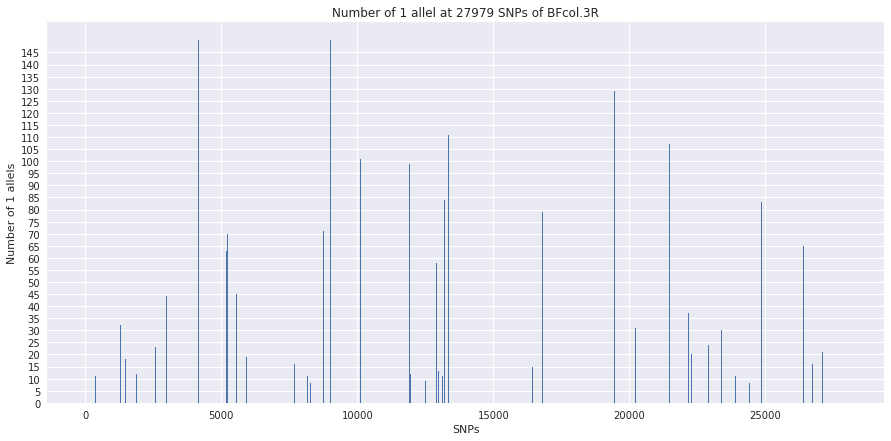

In [33]:
# Bar graph of Allels
plt.style.use('seaborn')
plt.figure(figsize=(15,7))
sums = haplotypeFF.sum(axis=1)
indexes = range(0,len(sums))
plt.bar(indexes,sums)
plt.xlabel('SNPs')
plt.ylabel('Number of 1 allels')
plt.title(f'Number of 1 allel at 27979 SNPs of {pop_name}')
plt.yticks(np.arange(0,155,5))